In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.distributions as dist
import torch
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from scripts.utils import ScaleData, train_keys
from scripts.AutoEncoder import AutoEncoderDataset
from tqdm import tqdm

import itertools
import seaborn as sns
#%matplotlib notebook
from tqdm import tqdm

In [2]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')

GPU device: 0


In [3]:
torch.cuda.device_count()

1

In [4]:
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
train_data = AutoEncoderDataset(train_data_path, columns = train_keys, train = True)
train_data.data = train_data.data.sample(100_000)
train_data.scale()

train_loader = DataLoader(train_data, shuffle = True, batch_size = 1024)

valid_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
valid_data = AutoEncoderDataset(valid_data_path, columns = train_keys, train = True)
valid_data.data = valid_data.data.sample(100_000)
valid_data.scale()

valid_loader = DataLoader(valid_data, shuffle = True, batch_size = 1024)

In [5]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

df_test = pd.read_pickle(test)
df_test = df_test.sample(10_000)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]

df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03,6.633000e+03
mean,6.669623e-17,-1.355768e-16,1.803673e-16,3.193084e-16,9.826804e-17,7.611547e-17,3.910940e-16,1.020592e-16,-3.311588e-17,9.329690e-17,5.186439e-17,7.555475e-17,7.350018e-17,4.743304e-16,-4.039267e-17
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-4.898531e+00,-4.301904e+00,-1.484548e+01,-1.644001e+00,-1.383666e+00,-1.275362e+00,-2.069906e+01,-1.169380e+00,-2.181364e+00,-3.195940e+00,-1.164715e+01,-7.412891e+00,-1.686743e+00,-2.817961e+00,-2.583028e+00
25%,-3.742496e-01,-5.678438e-01,-2.619801e-01,-5.326864e-01,-9.474992e-01,-8.169511e-01,4.014181e-02,-7.364102e-01,-6.545582e-01,-4.935636e-01,-3.348020e-01,-5.512120e-01,-2.566955e-01,-1.093560e-01,-7.198887e-01
50%,-1.879619e-01,-2.723099e-01,-2.619801e-01,-5.326864e-01,-1.405430e-01,-1.656191e-01,4.014181e-02,-3.021009e-01,-3.926616e-01,-3.469698e-01,-1.899593e-01,-2.519139e-01,-2.010104e-01,-1.093560e-01,-1.539245e-01
75%,7.445478e-02,1.943297e-01,-3.500034e-02,1.601299e-01,9.481858e-01,5.243449e-01,4.014181e-02,4.561829e-01,2.785231e-01,1.029299e-01,4.160282e-02,2.509507e-01,-9.365665e-02,-1.093560e-01,5.972833e-01
max,1.194332e+01,9.869968e+00,2.413887e+01,5.569359e+00,1.662172e+00,6.474970e+00,1.069204e+01,6.220629e+00,6.693203e+00,1.028978e+01,1.375674e+01,1.236867e+01,1.908740e+01,2.064346e+01,5.066276e+00


In [6]:
data_good = torch.from_numpy(df_test_good.values).float()
data_bad = torch.from_numpy(df_test_bad.values).float()
#data_good_batch = next(iter(data_good_loader))
# with torch.no_grad():
#     outputs_good = encoder.forward(data_good).sample()
#     outputs_bad = encoder.forward(data_bad).sample()
# #    outputs_good = encoder.forward(data_good).sample().detach().numpy()
    
# plt.figure()
# plt.scatter(outputs_good[:,0], outputs_good[:,1])
# plt.scatter(outputs_bad[:,0], outputs_bad[:,1])

# VAE 2

In [7]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
 
        # encoder
        self.enc1 = nn.Linear(in_features=15, out_features =150)
        self.enc2 = nn.Linear(in_features=150, out_features=75)
        self.enc3 = nn.Linear(in_features=75, out_features =30)
        self.enc4 = nn.Linear(in_features=30, out_features =10)
        self.mu = nn.Linear(10,5 )
        self.sigma = nn.Linear(10,5)
 
        # decoder 
        self.dec1 = nn.Linear(in_features = 5, out_features = 10)
        self.dec2 = nn.Linear(in_features = 10, out_features = 30)
        self.dec3 = nn.Linear(in_features = 30, out_features = 75)
        self.dec4 = nn.Linear(in_features = 75, out_features = 150)
        self.dec5 = nn.Linear(150, 15)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = F.relu(self.enc1(x.float()))
        x = F.relu(self.enc2(x.float()))
        x = F.relu(self.enc3(x.float()))
        x = F.relu(self.enc4(x.float()))
        # get `mu` and `log_var`
        mu = self.mu(x) # the first feature values as mean
        log_var = self.sigma(x) # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        z = F.relu(self.dec1(z.float()))
        z = F.relu(self.dec2(z.float()))
        z = F.relu(self.dec3(z.float()))
        z = F.relu(self.dec4(z.float()))
        
        reconstruction = self.dec5(z.float())
        return reconstruction.float(), mu.float(), log_var.float()

In [8]:
batch_size = 2048
lr = 1e-3
epochs = 100

model = LinearVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction ='none')

In [9]:
def final_loss(MSE_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = MSE_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [10]:
len(train_loader.dataset)

100000

In [11]:
def vae_loss(y_pred,y, mu, log_var): 
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))
    
    return reconstruction_error, kl_divergence

In [12]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    MSE_log = []
    KLD_log = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        #data, _ = data
        data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
#         MSE_loss = criterion(reconstruction.float(), data.float())
        MSE, KLD = vae_loss(reconstruction.float(), data.float(), mu, logvar)
        MSE_log.append(torch.mean(MSE).item())
        KLD_log.append(torch.mean(KLD).item())
        loss = (MSE + KLD).sum()
        running_loss += loss.item()
#         print(loss.item())
        loss.backward()
        optimizer.step()
    train_loss = running_loss
    return train_loss, MSE_log, KLD_log

In [13]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(valid_data)/dataloader.batch_size)):
            data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
#             MSE_loss = criterion(reconstruction.float(), data.float())
            mse, kld = vae_loss(reconstruction.float(), data.float(), mu, logvar)
            loss = (mse + kld).sum()
            running_loss += loss.item()
        
    val_loss = running_loss
    return val_loss

In [14]:
train_loss = []
val_loss = []
MSE_epoch = []
KLD_epoch = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, mse,kld = fit(model, train_loader)
    val_epoch_loss = validate(model, valid_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    MSE_epoch.append(np.mean(mse))
    KLD_epoch.append(np.mean(kld))
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 100


98it [00:09, 10.55it/s]                        
98it [00:08, 12.16it/s]                        


Train Loss: 753980.9819
Val Loss: 750810.8472
Epoch 2 of 100


98it [00:08, 11.32it/s]                        
98it [00:08, 11.93it/s]                        


Train Loss: 749883.4636
Val Loss: 744859.7244
Epoch 3 of 100


98it [00:08, 11.08it/s]                        
98it [00:08, 11.83it/s]                        


Train Loss: 715567.1802
Val Loss: 711487.9456
Epoch 4 of 100


98it [00:09, 10.75it/s]                        
98it [00:08, 12.14it/s]                        


Train Loss: 696279.6174
Val Loss: 700013.9683
Epoch 5 of 100


98it [00:08, 11.24it/s]                        
98it [00:08, 12.14it/s]                        


Train Loss: 672701.1802
Val Loss: 678088.7183
Epoch 6 of 100


98it [00:08, 11.23it/s]                        
98it [00:08, 11.92it/s]                        


Train Loss: 659021.3088
Val Loss: 670492.8955
Epoch 7 of 100


98it [00:08, 10.97it/s]                        
98it [00:08, 12.12it/s]                        


Train Loss: 648497.6064
Val Loss: 652616.7566
Epoch 8 of 100


98it [00:09, 10.56it/s]                        
98it [00:08, 12.06it/s]                        


Train Loss: 621195.2012
Val Loss: 641729.2852
Epoch 9 of 100


98it [00:08, 11.25it/s]                        
98it [00:08, 11.96it/s]                        


Train Loss: 618200.6721
Val Loss: 644524.4768
Epoch 10 of 100


98it [00:08, 10.93it/s]                        
98it [00:08, 12.05it/s]                        


Train Loss: 618782.8933
Val Loss: 652378.0986
Epoch 11 of 100


98it [00:08, 11.19it/s]                        
98it [00:08, 11.72it/s]                        


Train Loss: 622810.0422
Val Loss: 637724.3313
Epoch 12 of 100


98it [00:08, 11.15it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 616323.0935
Val Loss: 634082.4250
Epoch 13 of 100


98it [00:08, 11.23it/s]                        
98it [00:08, 11.65it/s]                        


Train Loss: 604427.3525
Val Loss: 631490.0249
Epoch 14 of 100


98it [00:08, 11.21it/s]                        
98it [00:08, 11.99it/s]                        


Train Loss: 601401.6833
Val Loss: 629663.9441
Epoch 15 of 100


98it [00:08, 11.25it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 599975.2168
Val Loss: 631787.9746
Epoch 16 of 100


98it [00:09, 10.74it/s]                        
98it [00:08, 11.73it/s]                        


Train Loss: 600796.1707
Val Loss: 628772.3845
Epoch 17 of 100


98it [00:08, 11.23it/s]                        
98it [00:08, 11.31it/s]                        


Train Loss: 605905.1956
Val Loss: 634185.8818
Epoch 18 of 100


98it [00:09, 10.46it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 602315.8101
Val Loss: 631016.8464
Epoch 19 of 100


98it [00:09, 10.78it/s]                        
98it [00:08, 11.95it/s]                        


Train Loss: 600624.9009
Val Loss: 626215.6943
Epoch 20 of 100


98it [00:08, 10.95it/s]                        
98it [00:08, 12.07it/s]                        


Train Loss: 597218.3770
Val Loss: 629010.3940
Epoch 21 of 100


98it [00:08, 11.13it/s]                        
98it [00:08, 11.70it/s]                        


Train Loss: 595808.3311
Val Loss: 626589.7942
Epoch 22 of 100


98it [00:08, 11.18it/s]                        
98it [00:08, 11.95it/s]                        


Train Loss: 595927.3435
Val Loss: 625068.8411
Epoch 23 of 100


98it [00:08, 10.91it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 596135.4961
Val Loss: 626704.5354
Epoch 24 of 100


98it [00:08, 11.20it/s]                        
98it [00:08, 11.84it/s]                        


Train Loss: 594485.8828
Val Loss: 625989.2161
Epoch 25 of 100


98it [00:08, 11.04it/s]                        
98it [00:08, 12.05it/s]                        


Train Loss: 593972.8030
Val Loss: 627400.5439
Epoch 26 of 100


98it [00:08, 10.94it/s]                        
98it [00:08, 11.94it/s]                        


Train Loss: 593748.9612
Val Loss: 630966.3982
Epoch 27 of 100


98it [00:08, 11.24it/s]                        
98it [00:08, 11.82it/s]                        


Train Loss: 598805.3384
Val Loss: 631036.8267
Epoch 28 of 100


98it [00:08, 11.26it/s]                        
98it [00:08, 12.12it/s]                        


Train Loss: 597364.9912
Val Loss: 631133.7004
Epoch 29 of 100


98it [00:08, 11.25it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 595893.3928
Val Loss: 621496.8567
Epoch 30 of 100


98it [00:08, 11.04it/s]                        
98it [00:08, 12.09it/s]                        


Train Loss: 591285.6497
Val Loss: 621723.8179
Epoch 31 of 100


98it [00:09, 10.68it/s]                        
98it [00:08, 12.08it/s]                        


Train Loss: 589099.2063
Val Loss: 622974.6113
Epoch 32 of 100


98it [00:09, 10.71it/s]                        
98it [00:08, 11.99it/s]                        


Train Loss: 587317.9529
Val Loss: 619885.2781
Epoch 33 of 100


98it [00:08, 11.17it/s]                        
98it [00:08, 11.66it/s]                        


Train Loss: 588385.2617
Val Loss: 628056.9778
Epoch 34 of 100


98it [00:08, 11.18it/s]                        
98it [00:08, 11.67it/s]                        


Train Loss: 591260.8699
Val Loss: 626171.9980
Epoch 35 of 100


98it [00:08, 11.03it/s]                        
98it [00:08, 11.35it/s]                        


Train Loss: 598625.5828
Val Loss: 633311.4988
Epoch 36 of 100


98it [00:09, 10.78it/s]                        
98it [00:08, 12.07it/s]                        


Train Loss: 597248.2607
Val Loss: 621950.0581
Epoch 37 of 100


98it [00:09, 10.71it/s]                        
98it [00:08, 12.03it/s]                        


Train Loss: 588180.6265
Val Loss: 620497.1284
Epoch 38 of 100


98it [00:09, 10.66it/s]                        
98it [00:08, 11.70it/s]                        


Train Loss: 590391.3176
Val Loss: 623791.5530
Epoch 39 of 100


98it [00:09, 10.87it/s]                        
98it [00:08, 11.84it/s]                        


Train Loss: 587793.9153
Val Loss: 623975.5588
Epoch 40 of 100


98it [00:08, 10.92it/s]                        
98it [00:08, 11.72it/s]                        


Train Loss: 589362.7810
Val Loss: 623772.6711
Epoch 41 of 100


98it [00:08, 10.99it/s]                        
98it [00:08, 12.04it/s]                        


Train Loss: 589903.0193
Val Loss: 633119.5796
Epoch 42 of 100


98it [00:08, 11.04it/s]                        
98it [00:08, 11.73it/s]                        


Train Loss: 594760.1743
Val Loss: 617554.7520
Epoch 43 of 100


98it [00:08, 11.21it/s]                        
98it [00:08, 11.96it/s]                        


Train Loss: 580268.6294
Val Loss: 619603.5615
Epoch 44 of 100


98it [00:08, 11.17it/s]                        
98it [00:08, 11.95it/s]                        


Train Loss: 578170.4487
Val Loss: 616145.1030
Epoch 45 of 100


98it [00:08, 10.93it/s]                        
98it [00:08, 12.03it/s]                        


Train Loss: 580706.8408
Val Loss: 625997.6704
Epoch 46 of 100


98it [00:08, 10.95it/s]                        
98it [00:08, 11.57it/s]                        


Train Loss: 579328.5232
Val Loss: 616668.2632
Epoch 47 of 100


98it [00:08, 11.18it/s]                        
98it [00:08, 11.89it/s]                        


Train Loss: 575406.6592
Val Loss: 618230.7871
Epoch 48 of 100


98it [00:09, 10.75it/s]                        
98it [00:08, 11.85it/s]                        


Train Loss: 576161.6614
Val Loss: 626026.5195
Epoch 49 of 100


98it [00:08, 10.95it/s]                        
98it [00:08, 11.92it/s]                        


Train Loss: 584101.7056
Val Loss: 613512.9006
Epoch 50 of 100


98it [00:08, 11.16it/s]                        
98it [00:08, 12.00it/s]                        


Train Loss: 574194.9241
Val Loss: 627178.3572
Epoch 51 of 100


98it [00:09, 10.78it/s]                        
98it [00:08, 11.94it/s]                        


Train Loss: 590706.7524
Val Loss: 618299.0730
Epoch 52 of 100


98it [00:08, 10.98it/s]                        
98it [00:08, 11.90it/s]                        


Train Loss: 573235.7371
Val Loss: 621896.4185
Epoch 53 of 100


98it [00:08, 11.13it/s]                        
98it [00:08, 11.66it/s]                        


Train Loss: 582026.2219
Val Loss: 612933.6863
Epoch 54 of 100


98it [00:09, 10.62it/s]                        
98it [00:08, 11.87it/s]                        


Train Loss: 571352.7930
Val Loss: 613060.0557
Epoch 55 of 100


98it [00:08, 11.17it/s]                        
98it [00:08, 12.04it/s]                        


Train Loss: 566737.6516
Val Loss: 622255.9985
Epoch 56 of 100


98it [00:08, 11.09it/s]                        
98it [00:08, 12.00it/s]                        


Train Loss: 568534.2200
Val Loss: 616503.2175
Epoch 57 of 100


98it [00:08, 10.91it/s]                        
98it [00:08, 11.78it/s]                        


Train Loss: 566613.0774
Val Loss: 612516.3967
Epoch 58 of 100


98it [00:08, 11.02it/s]                        
98it [00:08, 11.89it/s]                        


Train Loss: 566377.8865
Val Loss: 621327.0496
Epoch 59 of 100


98it [00:09, 10.15it/s]                        
98it [00:08, 11.85it/s]                        


Train Loss: 577392.7849
Val Loss: 613418.3975
Epoch 60 of 100


98it [00:08, 11.05it/s]                        
98it [00:08, 11.91it/s]                        


Train Loss: 560619.7827
Val Loss: 612254.3118
Epoch 61 of 100


98it [00:09, 10.14it/s]                        
98it [00:08, 11.93it/s]                        


Train Loss: 558990.4185
Val Loss: 611189.2537
Epoch 62 of 100


98it [00:09, 10.79it/s]                        
98it [00:08, 11.92it/s]                        


Train Loss: 557114.6233
Val Loss: 615241.4976
Epoch 63 of 100


98it [00:08, 10.93it/s]                        
98it [00:08, 11.82it/s]                        


Train Loss: 565260.0315
Val Loss: 623867.5513
Epoch 64 of 100


98it [00:09, 10.65it/s]                        
98it [00:08, 11.57it/s]                        


Train Loss: 568289.7295
Val Loss: 633369.6267
Epoch 65 of 100


98it [00:09, 10.53it/s]                        
98it [00:08, 11.73it/s]                        


Train Loss: 580552.3599
Val Loss: 612929.1189
Epoch 66 of 100


98it [00:08, 11.07it/s]                        
98it [00:08, 11.80it/s]                        


Train Loss: 560014.0261
Val Loss: 605843.4197
Epoch 67 of 100


98it [00:09, 10.46it/s]                        
98it [00:08, 11.25it/s]                        


Train Loss: 556697.1912
Val Loss: 608458.8450
Epoch 68 of 100


98it [00:08, 10.96it/s]                        
98it [00:08, 11.62it/s]                        


Train Loss: 557391.1602
Val Loss: 608464.3450
Epoch 69 of 100


98it [00:08, 10.97it/s]                        
98it [00:08, 11.80it/s]                        


Train Loss: 556430.5820
Val Loss: 605375.3438
Epoch 70 of 100


98it [00:09, 10.47it/s]                        
98it [00:08, 11.79it/s]                        


Train Loss: 556650.0847
Val Loss: 602429.0889
Epoch 71 of 100


98it [00:09, 10.87it/s]                        
98it [00:08, 11.62it/s]                        


Train Loss: 554950.4282
Val Loss: 623454.6038
Epoch 72 of 100


98it [00:08, 10.98it/s]                        
98it [00:08, 11.57it/s]                        


Train Loss: 564682.8740
Val Loss: 603971.1782
Epoch 73 of 100


98it [00:08, 10.92it/s]                        
98it [00:08, 11.23it/s]                        


Train Loss: 558717.2039
Val Loss: 620659.8677
Epoch 74 of 100


98it [00:09, 10.78it/s]                        
98it [00:08, 11.80it/s]                        


Train Loss: 580543.7610
Val Loss: 601659.7395
Epoch 75 of 100


98it [00:09, 10.71it/s]                        
98it [00:08, 11.62it/s]                        


Train Loss: 553623.1558
Val Loss: 605237.6912
Epoch 76 of 100


98it [00:09, 10.61it/s]                        
98it [00:08, 11.44it/s]                        


Train Loss: 553135.0452
Val Loss: 609308.6187
Epoch 77 of 100


98it [00:09, 10.81it/s]                        
98it [00:08, 11.74it/s]                        


Train Loss: 556330.5898
Val Loss: 602230.6157
Epoch 78 of 100


98it [00:08, 10.95it/s]                        
98it [00:08, 11.59it/s]                        


Train Loss: 552606.0881
Val Loss: 618713.7158
Epoch 79 of 100


98it [00:09, 10.63it/s]                        
98it [00:08, 11.51it/s]                        


Train Loss: 557914.4204
Val Loss: 601154.3381
Epoch 80 of 100


98it [00:09, 10.88it/s]                        
98it [00:08, 11.62it/s]                        


Train Loss: 549095.8315
Val Loss: 605026.6812
Epoch 81 of 100


98it [00:08, 10.90it/s]                        
98it [00:08, 11.75it/s]                        


Train Loss: 549928.2517
Val Loss: 600418.3291
Epoch 82 of 100


98it [00:08, 10.91it/s]                        
98it [00:08, 11.75it/s]                        


Train Loss: 549231.4695
Val Loss: 612459.0032
Epoch 83 of 100


98it [00:09, 10.87it/s]                        
98it [00:08, 11.73it/s]                        


Train Loss: 555832.9768
Val Loss: 603507.0552
Epoch 84 of 100


98it [00:08, 10.95it/s]                        
98it [00:09, 10.76it/s]                        


Train Loss: 547995.3154
Val Loss: 613450.1567
Epoch 85 of 100


98it [00:09, 10.71it/s]                        
98it [00:08, 11.52it/s]                        


Train Loss: 555470.1719
Val Loss: 598844.1577
Epoch 86 of 100


98it [00:09, 10.87it/s]                        
98it [00:08, 11.43it/s]                        


Train Loss: 546127.2131
Val Loss: 609361.4407
Epoch 87 of 100


98it [00:09, 10.88it/s]                        
98it [00:08, 11.53it/s]                        


Train Loss: 555801.9363
Val Loss: 594880.4810
Epoch 88 of 100


98it [00:09, 10.86it/s]                        
98it [00:08, 11.77it/s]                        


Train Loss: 551410.2056
Val Loss: 619723.7544
Epoch 89 of 100


98it [00:09, 10.42it/s]                        
98it [00:08, 11.78it/s]                        


Train Loss: 557570.6416
Val Loss: 627581.3188
Epoch 90 of 100


98it [00:09, 10.74it/s]                        
98it [00:08, 11.46it/s]                        


Train Loss: 550837.4558
Val Loss: 603272.7566
Epoch 91 of 100


98it [00:09, 10.81it/s]                        
98it [00:08, 11.74it/s]                        


Train Loss: 549071.8499
Val Loss: 596734.8110
Epoch 92 of 100


98it [00:09, 10.19it/s]                        
98it [00:08, 11.77it/s]                        


Train Loss: 538489.3992
Val Loss: 597481.0488
Epoch 93 of 100


98it [00:08, 10.91it/s]                        
98it [00:08, 11.77it/s]                        


Train Loss: 540475.3306
Val Loss: 600081.3252
Epoch 94 of 100


98it [00:08, 10.96it/s]                        
98it [00:08, 11.76it/s]                        


Train Loss: 538414.1555
Val Loss: 604841.7017
Epoch 95 of 100


98it [00:08, 10.92it/s]                        
98it [00:08, 11.73it/s]                        


Train Loss: 538795.4431
Val Loss: 599947.7485
Epoch 96 of 100


98it [00:09, 10.54it/s]                        
98it [00:08, 11.80it/s]                        


Train Loss: 539391.3296
Val Loss: 607407.1772
Epoch 97 of 100


98it [00:08, 10.96it/s]                        
98it [00:08, 11.72it/s]                        


Train Loss: 554489.4922
Val Loss: 595544.3398
Epoch 98 of 100


98it [00:09, 10.88it/s]                        
98it [00:08, 11.76it/s]                        


Train Loss: 534126.1665
Val Loss: 598768.9998
Epoch 99 of 100


98it [00:09, 10.39it/s]                        
98it [00:08, 11.01it/s]                        


Train Loss: 532726.4622
Val Loss: 594245.4937
Epoch 100 of 100


98it [00:08, 10.91it/s]                        
98it [00:08, 11.67it/s]                        

Train Loss: 534931.4851
Val Loss: 597098.1150


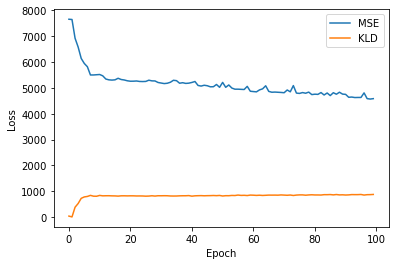

In [15]:
plt.figure()
plt.plot(MSE_epoch, label ='MSE')
plt.plot(KLD_epoch, label = 'KLD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [16]:
model.to('cpu')
AE_output2,_,_ = model(data_good)
AE_output2 = AE_output2.detach().numpy()
df_ae_output2 = pd.DataFrame(AE_output2, columns = train_keys)
df_ae_output2['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

df_compare2 = pd.concat([df_ae_output2, df_test_tmp], ignore_index=True)
df_compare_sample2= df_compare2.sample(10_000)

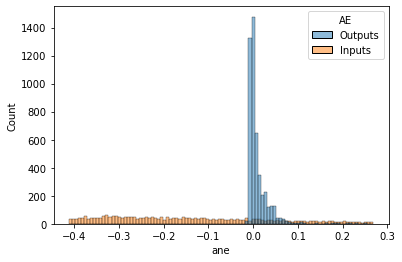

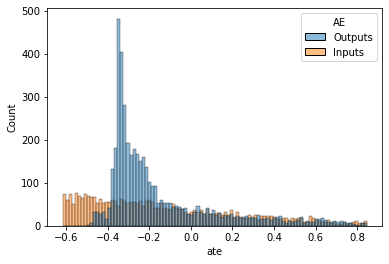

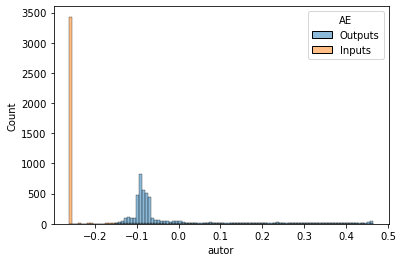

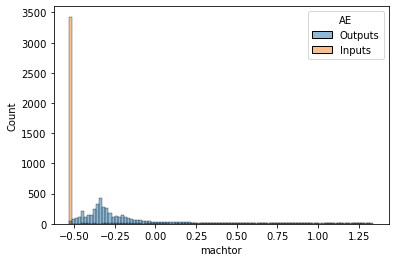

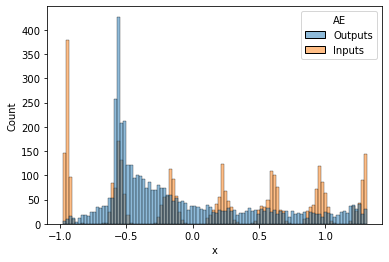

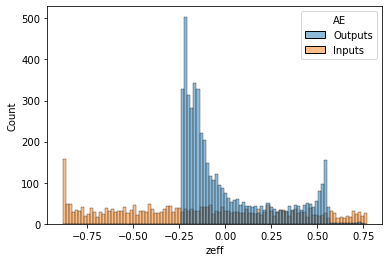

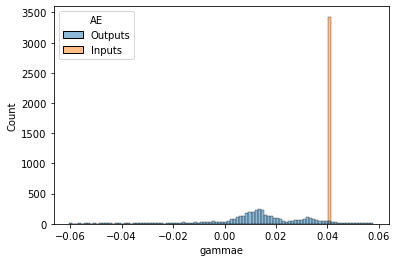

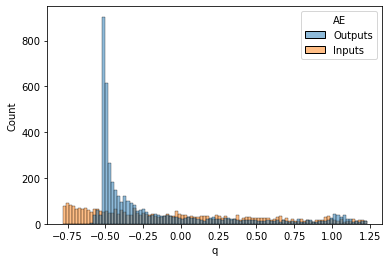

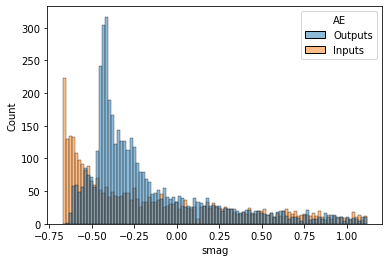

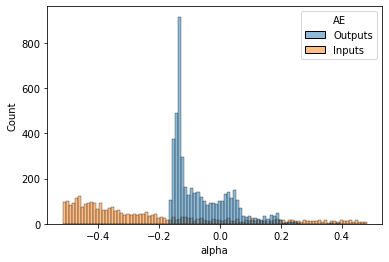

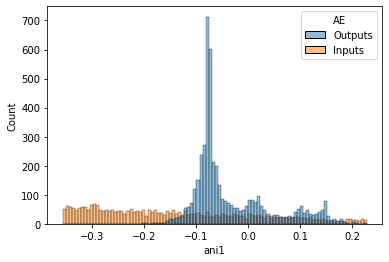

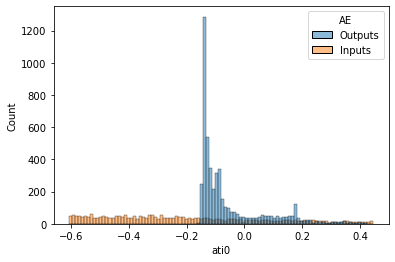

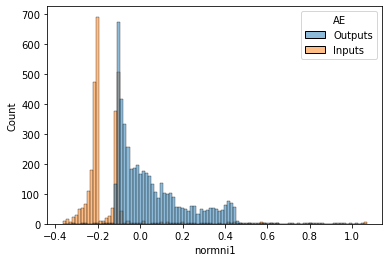

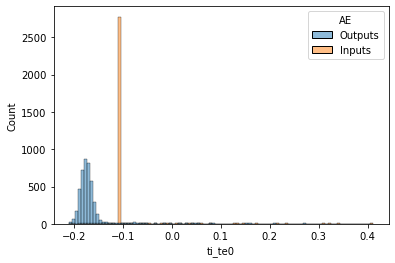

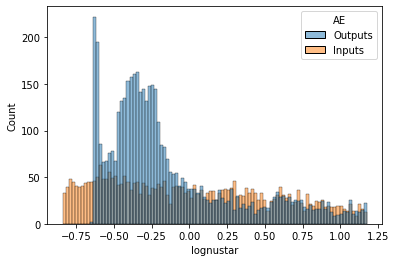

In [17]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample2[i].quantile(0.1)
    x_max = df_compare_sample2[i].quantile(0.9)
    sns.histplot(data = df_compare_sample2, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)